Support algs imported!


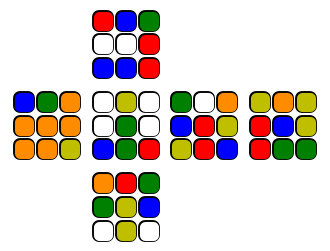

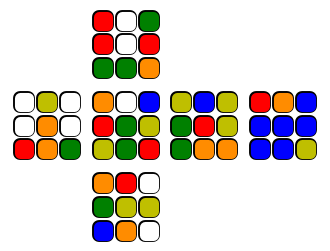

Cube initiated


'\ncube\n\n'

In [6]:
import random
import time
import json
%run Cube.ipynb

'''
cube

'''

In [7]:
# gen all 2-gen states for corners
def get_corner_state(cube):
    '''cube in mode 4'''
    corner_state = ""
    for i in [0,2,6,8,18,20,24,26]:
        corner_state += str(cube.state[i])
    return int(corner_state)

# make cp_states
cp_states = []

cube = Cube(4)
moveset = ["R","R'","R2","U","U'","U2"]      
for i in range(10000):
    state = get_corner_state(cube)
    if state not in cp_states:
        cp_states.append(state)
    move = random.choice(moveset)
    cube.apply_moves(move)

In [34]:
def get_eo_state(cube):
    ''' cube in mode 5 '''
    eo_state = ""#"1"
    for i in [28, 1, 10, 12, 16, 14]:#[1,7,10,12,14,16,19,25,28,30,32,34]:
        eo_state += str(cube.state[i])
    return 63-int(eo_state, base=2)


for i in [1,2,4,8,16,32]:
    for j in [1,2,4,8,16,32]:
        for k in [1,2,4,8,16,32]:
            for l in [0,1,2,4,8,16,32]:
                if i>j>k>l:
                    print(i+j+k+l)
        




7
11
13
14
15
19
21
22
23
25
26
27
28
29
30
35
37
38
39
41
42
43
44
45
46
49
50
51
52
53
54
56
57
58
60


In [4]:
# check if cube in mode 0 has 2x2x3 block solved
@njit
def block223_solved(cubestate):
    ''' Assumes cube in mode 0 '''
    if cubestate[3]==cubestate[6]==cubestate[7]==cubestate[4]==1 and cubestate[22]==cubestate[23]==cubestate[25]==cubestate[26]==3 and cubestate[30]==cubestate[31]==cubestate[32]==cubestate[33]==cubestate[34]==cubestate[35]==4 and cubestate[45]==cubestate[46]==cubestate[48]==cubestate[49]==cubestate[51]==cubestate[52]==6: 
        return True
    return False

cube = Cube()
cube.apply_moves("R U")
block223_solved(cube.state)

True

In [5]:
class alg_index_special:
    def __init__(self, length):
        '''
        length: int
        '''
        self.length = length
#         self.moves = ["R","R'","R2","U","U'","U2","F","F'","F2","f","f'","f2","S","S'","S2"] # <RUFfS>
        self.moves = ["R","R'","R2","r","r'","r2","U","U'","U2","D","D'","D2"] # <RrUD>
        self.ids = np.array(([0,3]*int(length/2+1))[:length])
        
    def is_valid(self):
        for i in range(self.length-1):
            if self.ids[i]//3==self.ids[i+1]//3:
                return False
#             if self.ids[i]//3 in [2,3,4] and self.ids[i+1]//3 in [2,3,4]: # <RUFfS>
#                 return False
            if self.ids[i]//3 and self.ids[i+1]//3: # <RrUD>
                return False
        return True   
        
    def inc(self):
        for i in range(len(self.ids)):
            self.ids[i]+=1
            self.ids[i]%=len(self.moves)
            if self.ids[i]:
                break
    
    def increment(self):
        self.inc()
        while not self.is_valid():
            self.inc()
        
    def get_alg(self):
        scr = self.moves[self.ids[0]]
        for i in range(1,len(self.ids)):
            scr += f" {self.moves[self.ids[i]]}"
        return scr

In [63]:
def gen_special_algs(n=3):
    algs = []
    t = time.time()
    tot_algs = 0
    for i in range(1,n+1):
        alg = alg_index_special(i)
        start_alg = alg.get_alg()
        algs.append(alg.get_alg())
        alg.increment()
        while start_alg != alg.get_alg():
            algs.append(alg.get_alg())
            alg.increment()
        print(i,"genned in",time.time()-t, f"({len(algs)-tot_algs} algs)")
        tot_algs += len(algs)
    return algs

In [66]:
# eo_state: list of algs that solves that eo_state
def gen_eo_dict(n = 5):
    eo_dict = {}

    algs = gen_special_algs(n)

    for alg in algs:
        # make EO cube
        cube = Cube(5)
        cube.apply_moves(alg)
        state = get_eo_state(cube)
        if state in eo_dict.keys():
            eo_dict[state] += [inverse_alg(alg)]
        else:
            eo_dict[state] = [inverse_alg(alg)]
    return eo_dict

eo_dict = gen_eo_dict(6)

1 genned in 0.0 (12 algs)
2 genned in 0.0010006427764892578 (54 algs)
3 genned in 0.005516529083251953 (312 algs)
4 genned in 0.06957411766052246 (1380 algs)
5 genned in 0.6546902656555176 (8280 algs)
6 genned in 7.026554822921753 (37050 algs)


In [67]:
len(eo_dict)

84

In [17]:
'''
Gen all eo cases (make new cube, "manually" change eo on cube5 = cube(5)). For each case:
1) brute force moves up to length 3(?)
2) lookup to get EO solution (if applicable), save all solutions
3) go through all solutions again on the new cubes: cube0 = cube(0) and cube4 = cube(4) with corners swapped. Only save algs where block223_solved(cube0) and get_corner_state(cube4) are in cp_states
'''

'\nGen all eo cases (make new cube, "manually" change eo on cube5 = cube(5)). For each case:\n1) brute force moves up to length 3(?)\n2) lookup to get EO solution (if applicable), save all solutions\n3) go through all solutions again on the new cubes: cube0 = cube(0) and cube4 = cube(4) with corners swapped. Only save algs where block223_solved(cube0) and get_corner_state(cube4) are in cp_states\n'

In [35]:
def gen_eo_case(k):
    '''
    k in <0,1,2,...,63>
    returns cube with the corresponding EO
    '''
    edges = [[28,39], [1,43], [10,41], [12,5], [16,50], [14,21]]
    cube = Cube(5)
    bit = bin(k+64)[3:]
    for i,j in enumerate(bit):
        j = int(j)
        if j:
            cube.state[edges[i][0]],cube.state[edges[i][1]] = cube.state[edges[i][1]],cube.state[edges[i][0]]
    if bit.count("1")%2:
        cube.state[19],cube.state[37] = cube.state[37],cube.state[19]
    return cube
            
    
    
# cube = Cube(5)
# cube.state = np.array([0]*54)
# cube.state[14] = cube.state[21] = 1
# cube.state[16] = cube.state[50] = 2
# cube.state[12] = cube.state[5] = 3
# cube.state[10] = cube.state[41] = 4
# cube.state[1]  = cube.state[43] = 5
# cube.state[28] = cube.state[39] = 6
# print(cube)


# k = 27
# gen_eo_case(k)

In [69]:
algs_2gen = {}

setup_algs = gen_special_algs(3)

t = time.time()
for k in range(1,64):
    potential_algs = []
    
    for alg in setup_algs:
        cube = gen_eo_case(k)
        cube.apply_moves(alg)
        eo_state = get_eo_state(cube)
        if eo_state in eo_dict.keys():
            for sol in eo_dict[eo_state]:
                potential_algs += [alg + " " + sol]
                
    print("Potential algs created")
    working_algs = []
    for alg in potential_algs:
        cube0 = Cube(0)
        cube4 = Cube(4)
        cube4.apply_algs("pp_corners")
        
        cube0.apply_moves(alg)
        cube4.apply_moves(alg)
        if block223_solved(cube0.state) and get_corner_state(cube4) in cp_states:
            working_algs += [alg]
    
    algs_2gen[k] = working_algs
    print(f"{k} - {time.time()-t}")

1 genned in 0.0 (12 algs)
2 genned in 0.0009975433349609375 (54 algs)
3 genned in 0.005993843078613281 (312 algs)
Potential algs created
1 - 0.2535691261291504
Potential algs created
2 - 0.42174458503723145
Potential algs created
3 - 0.450275182723999
Potential algs created
4 - 0.6514866352081299
Potential algs created
5 - 0.6589977741241455
Potential algs created
6 - 0.688032865524292
Potential algs created
7 - 0.7385828495025635
Potential algs created
8 - 0.935673713684082
Potential algs created
9 - 0.9652004241943359
Potential algs created
10 - 1.0117497444152832
Potential algs created
11 - 1.0665345191955566
Potential algs created
12 - 1.096308708190918
Potential algs created
13 - 1.1268408298492432
Potential algs created
14 - 1.1831204891204834
Potential algs created
15 - 1.2242305278778076
Potential algs created
16 - 1.231231451034546
Potential algs created
17 - 1.4322261810302734
Potential algs created
18 - 1.6560051441192627
Potential algs created
19 - 2.865588665008545
Potenti

In [71]:
for k in range(1,64):
    if algs_2gen_cp_solved[k]:
        print(k,bin(k)[2:],algs_2gen_cp_solved[k][0])

35 100011 D R r' R' U' R' r R D'
54 110110 D' R r R' U R' r' R D


In [135]:
import json
with open("EO.json", "w") as outfile:
    json.dump(algs_2gen_cp_solved, outfile, indent=4)

In [98]:
# new_dict = {}
# for k in algs_2gen.keys():
#     new_dict[k] = algs_2gen[k][:10]

In [99]:
def plot_eo_case(cube):
    ''' cube in mode 5 '''
    plt_cube = Cube()
    plt_cube.state = np.array([0]*54)
    edges = [[28,1,10,12,16,14,19,7,25,30,34,48],[39,43,41,5,50,21,37,46,52,23,48,3]]
    
    for i,j in enumerate(edges[1]):
        if cube.state[j]:
            plt_cube.state[j] = 5
            plt_cube.state[edges[0][i]] = 5
    
    plt_cube.plot()
    
# for k in range(64):
#     print(k)
#     cube = gen_eo_case(k)
#     plot_eo_case(cube)

In [100]:
# with open("CPEO.json", "r") as outfile:
#     algs_2gen = json.load(outfile)
    
# algs_2gen

In [102]:
# for k in algs_2gen.keys():
#     for i in range(len(algs_2gen[k])):
#         algs_2gen[k][i] = cancel_alg(algs_2gen[k][i])


# for k in algs_2gen.keys():
#     new_algs = []
#     for i in range(len(algs_2gen[k])):
#         if not (algs_2gen[k][i].split(" ")[-1][0] == "R" or algs_2gen[k][i].split(" ")[-1][0] == "U") and algs_2gen[k][i] not in new_algs:
#             new_algs.append(algs_2gen[k][i])
#     algs_2gen[k] = new_algs
            
# algs_2gen

In [146]:
# algs_2gen_cp_solved_1 = {}

# for k in algs_2gen.keys():
#     algs_2gen_cp_solved_1[int(k)] = algs_2gen_cp_solved[int(k)][1]
        
        


In [89]:
# algs_2gen["63"]

In [147]:
# with open("EO_1_alg.json", "w") as outfile:
#     json.dump(algs_2gen_cp_solved_1, outfile, indent=4)